In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
hapData = read.csv("/mnt/tmpData/FIDA240_01DKD2-BGL-T1A1.csv")

In [3]:
hapData[1:2,1:10]

,X,HB1__1067.1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067.1_f,HB2__32843_f
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,01DKD2-BGL-T1A1,0,0,0,0,0,2,0,0,0
2,FIDA240,0,0,0,2,0,0,0,0,0


In [4]:
row.names(hapData) = hapData[,1]

In [5]:
hapData = hapData[,-1]

In [6]:
targetHap = read.csv('/mnt/tmpData/01DKD2-BGL-T1A1_17IFI6.csv',check.names = FALSE)

In [7]:
head(targetHap[,1:10])

,,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,0,0,0,0,0,1,0,0,0


In [8]:
targetHap = targetHap[,-1]

## 01DKD2 to FIDA240 at Chr6

In [9]:
mmIndex = which(hapData[1,] != hapData[2,])

In [10]:
length(mmIndex)

[1] 6453

In [11]:
mmIndexName = colnames(hapData)[mmIndex]
mmBinIndex = as.numeric(sapply(mmIndexName,function(x){return(as.numeric(str_replace(unlist(strsplit(x,"__"))[1],"HB","")))}))

In [12]:
head(mmIndexName)

[1] "HB1__B73_f" "HB1__NA_f"  "HB2__B73_f" "HB2__NA_f"  "HB3__B73_f"
[6] "HB3__NA_f"

In [13]:
indexRange = 9843:11146 # chr6 bins

In [17]:
bins = 0
for(bin in unique(mmBinIndex)){
    if(bin %in% indexRange){
        tmp = targetHap[1,]
        index2 = which(mmBinIndex == bin)
        binNames = mmIndexName[index2]
        tmp[,binNames] = hapData["FIDA240",binNames]

        targetHap = bind_rows(targetHap,tmp) 
        bins = c(bins,bin) 
    }
}
row.names(targetHap) = bins

In [32]:
write.csv(targetHap,"/mnt/tmpData/mutatedHapToFIDA240_chr2.csv")

In [17]:
# prediction based mutated
mutPred = read.csv("/mnt/tmpData/pred_value_mutate_FIDA240_chr2.csv")

In [18]:
head(mutPred)

,Unnamed..0,X0
,<int>,<dbl>
1,0,-30.31488
2,9843,-30.07883
3,9965,-30.32574
4,9966,-30.30404
5,9967,-30.29187
6,9968,-30.38667


In [19]:
colnames(mutPred) = c("binIndex","pred_value")

In [20]:
baseValue = mutPred$pred_value[1]
mutPred = mutPred[-1,]

In [21]:
binMap = read.csv("/mnt/data/newPredictionMap.csv")

In [22]:
head(binMap)

,genMapChr_MONv6,genMapPos_MONv6,index
,<int>,<dbl>,<int>
1,1,0.0,1
2,1,0.1,2
3,1,0.2,3
4,1,0.3,4
5,1,0.4,5
6,1,0.5,6


In [23]:
mutPred$genMapChr_MONv6 = binMap[mutPred$binIndex,"genMapChr_MONv6"]
mutPred$genMapPos_MONv6 = binMap[mutPred$binIndex,"genMapPos_MONv6"]

In [24]:
head(mutPred)

,binIndex,pred_value,genMapChr_MONv6,genMapPos_MONv6
,<int>,<dbl>,<int>,<dbl>
2,9843,-30.07883,6,0.0
3,9965,-30.32574,6,12.2
4,9966,-30.30404,6,12.3
5,9967,-30.29187,6,12.4
6,9968,-30.38667,6,12.5
7,9969,-30.36832,6,12.6


In [25]:
tail(mutPred)

,binIndex,pred_value,genMapChr_MONv6,genMapPos_MONv6
,<int>,<dbl>,<int>,<dbl>
199,10185,-30.37037,6,34.2
200,10186,-30.45050,6,34.3
201,10187,-30.38635,6,34.4
202,10188,-30.38459,6,34.5
203,10190,-30.39111,6,34.7
204,10192,-30.46812,6,34.9


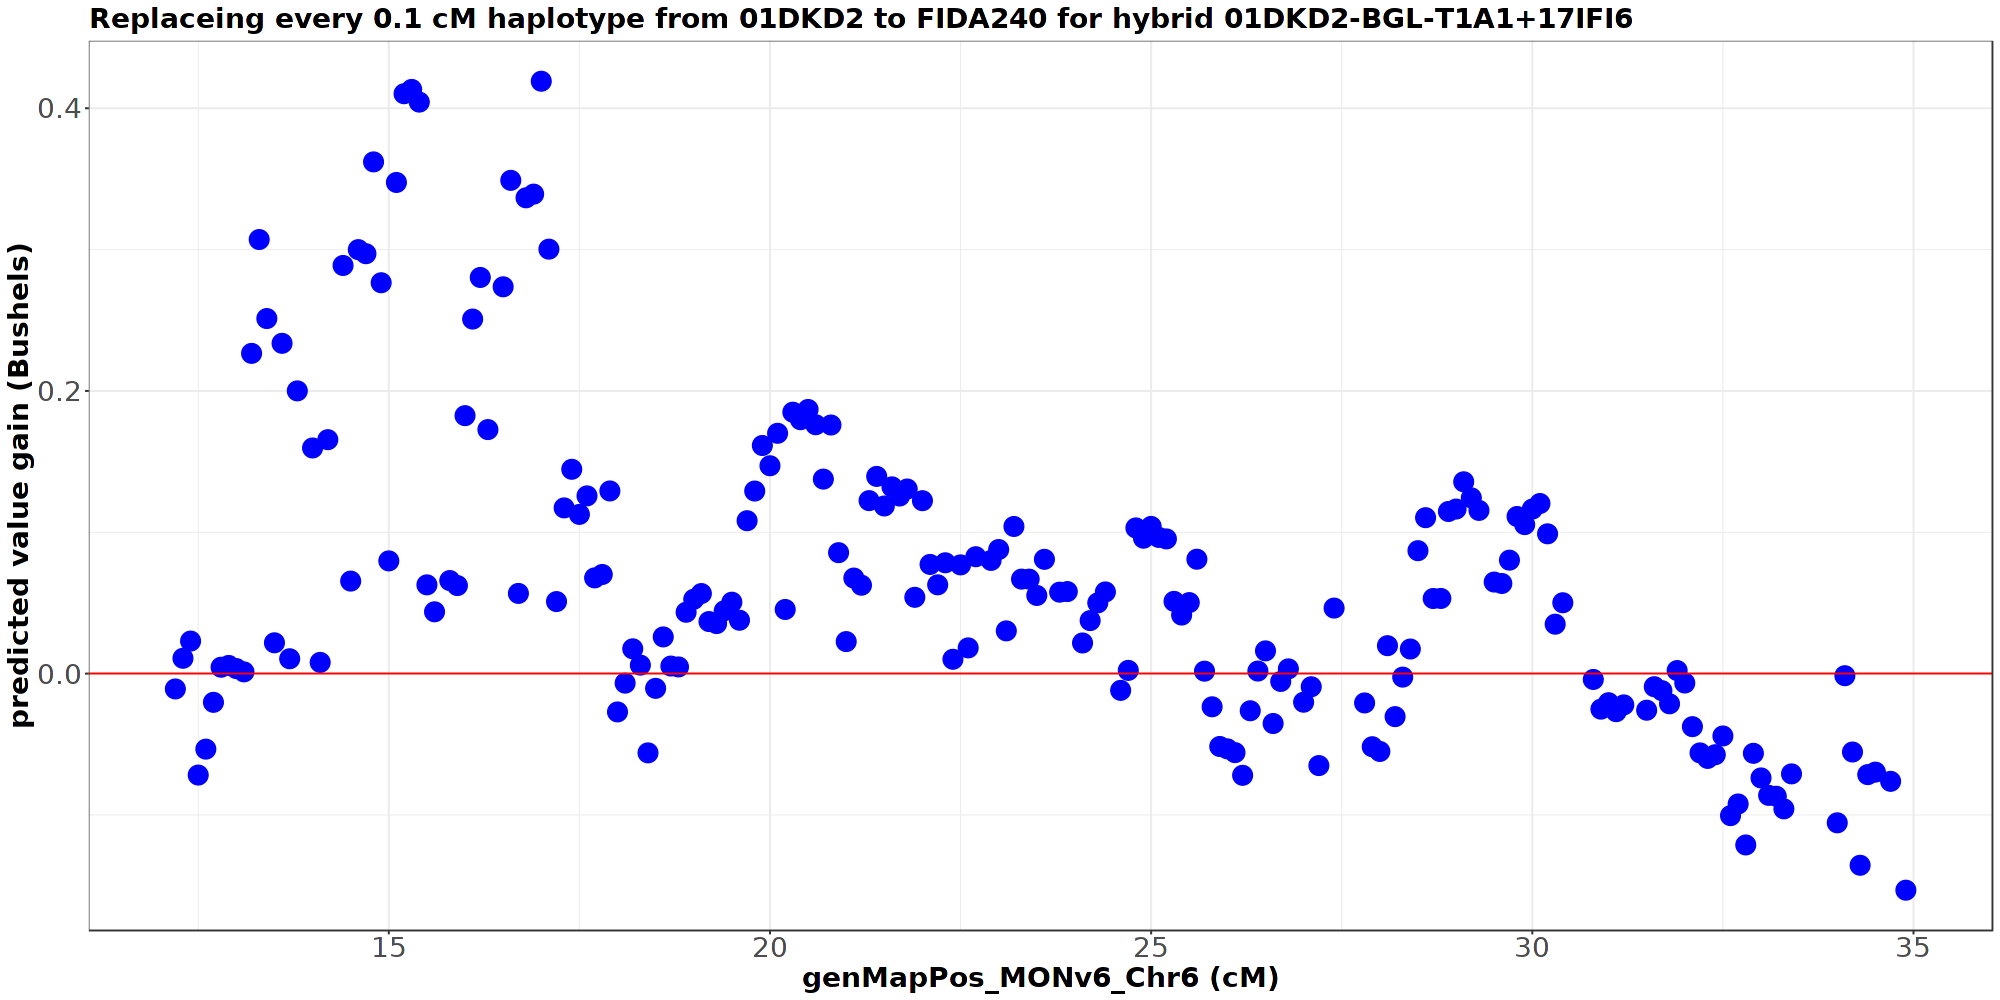

In [27]:
options(repr.plot.width = 20, repr.plot.height = 10, repr.plot.res = 100)
ggplot(mutPred[-1,],aes(genMapPos_MONv6,pred_value - baseValue)) + geom_point(col="blue",size=6) + theme_bw() + 
    geom_hline(yintercept = 0,col="red") + 
ggtitle("Replaceing every 0.1 cM haplotype from 01DKD2 to FIDA240 for hybrid 01DKD2-BGL-T1A1+17IFI6") + 
xlab("genMapPos_MONv6_Chr6 (cM)") + ylab("predicted value gain (Bushels)") +
    theme(axis.text=element_text(size=20),plot.title = element_text(size = 20, face = "bold"),
        axis.title=element_text(size=20,face="bold"))

In [25]:
sum(mutPred$pred_value - (-30.31488))

[1] 13.64842

In [32]:
# all column names of female data
fHapIndex = data.frame(hap = colnames(hapData))
fHapIndex$binIndex = as.numeric(sapply(fHapIndex$hap,function(x){return(as.numeric(str_replace(unlist(strsplit(x,"__"))[1],"HB","")))}))
fHapIndex$index = 1:nrow(fHapIndex)

In [33]:
head(fHapIndex)

,hap,binIndex,index
,<chr>,<dbl>,<int>
1,HB1__1067.1_f,1,1
2,HB1__32843_f,1,2
3,HB1__64DWA2_f,1,3
4,HB1__B73_f,1,4
5,HB1__MANS_f,1,5
6,HB1__NA_f,1,6


### at Chr6 from 12.2 to 34.9 cM, slide by 1 cM

In [83]:
##
stIndex = 9965
edIndex = 10192
allIndex = seq(9965,10192,by=5)
binSt = 0
for(st in allIndex){
    ed = st + 49 # 5 cM each seg
    targetIndex = which(fHapIndex$binIndex >= st & fHapIndex$binIndex <= ed)
    tmp = targetHap[1,]
    tmp[,targetIndex] = hapData["FIDA240",targetIndex]
    targetHap = bind_rows(targetHap,tmp) 
    binSt = c(binSt,st)
}


In [84]:
dim(targetHap)
row.names(targetHap) = binSt
targetHap[1:5,1:10]


[1]     47 109598

,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f,HB2__64DWA2_f
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,1,0,0,0,0
9965,0,0,0,0,0,1,0,0,0,0
9970,0,0,0,0,0,1,0,0,0,0
9975,0,0,0,0,0,1,0,0,0,0
9980,0,0,0,0,0,1,0,0,0,0


In [85]:
write.csv(targetHap,"/mnt/tmpData/mutatedHapToFIDA240_chr2_5cM_slideByHalfcM.csv")

In [45]:
head(binSt)

[1]     0  9965  9975  9985  9995 10005

In [28]:
# prediction based mutated
#mutPred = read.csv("/mnt/tmpData/pred_value_mutate_FIDA240_chr2_5cM_slideBy1cM.csv")
# prediction based mutated
mutPred = read.csv("/mnt/tmpData/pred_value_mutate_FIDA240_chr2_5cM_slideByHalfcM.csv")

In [29]:
head(mutPred)

,Unnamed..0,X0
,<int>,<dbl>
1,0,-30.31488
2,9965,-20.54042
3,9970,-19.72339
4,9975,-19.39468
5,9980,-20.47089
6,9985,-20.70244


In [30]:
colnames(mutPred) = c("binIndex","pred_value")
baseValue = mutPred$pred_value[1]
mutPred = mutPred[-1,]
mutPred$genMapChr_MONv6 = binMap[mutPred$binIndex,"genMapChr_MONv6"]
mutPred$genMapPos_MONv6 = binMap[mutPred$binIndex,"genMapPos_MONv6"]

In [31]:
head(mutPred)

,binIndex,pred_value,genMapChr_MONv6,genMapPos_MONv6
,<int>,<dbl>,<int>,<dbl>
2,9965,-20.54042,6,12.2
3,9970,-19.72339,6,12.7
4,9975,-19.39468,6,13.2
5,9980,-20.47089,6,13.7
6,9985,-20.70244,6,14.2
7,9990,-21.35581,6,14.7


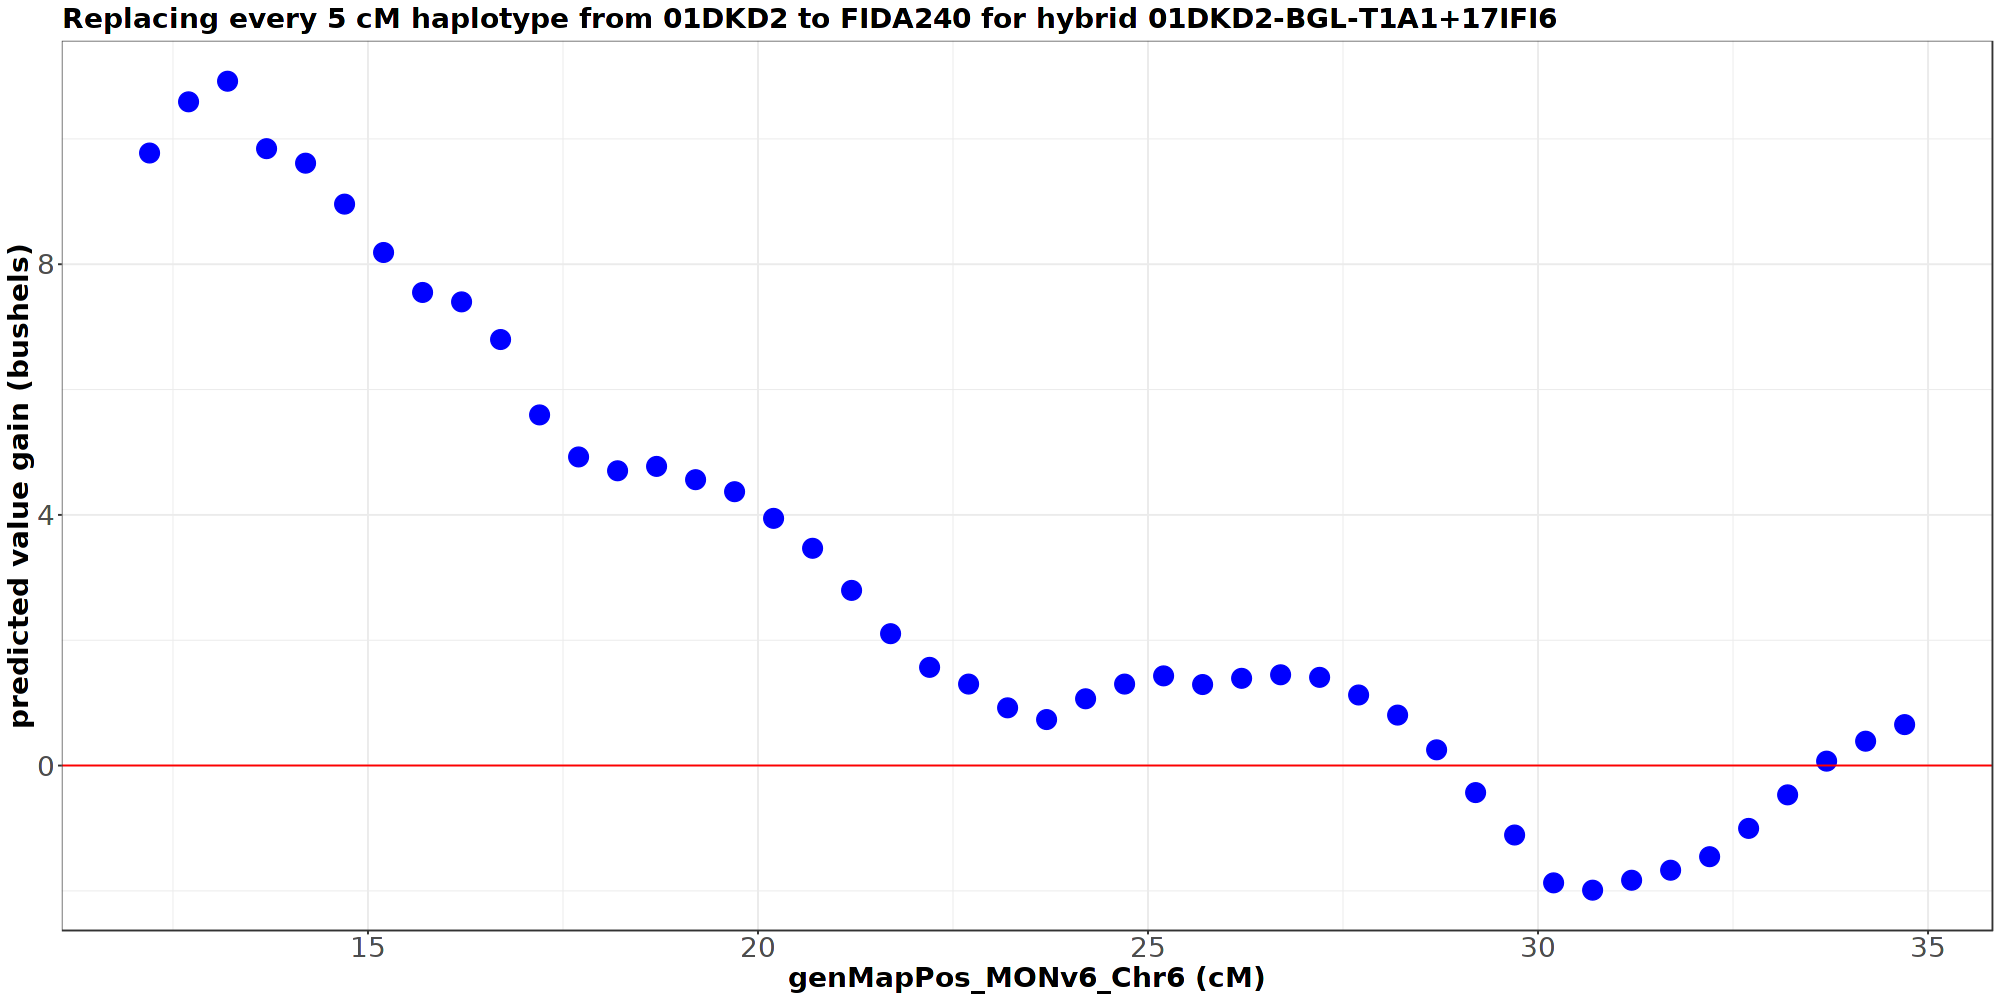

In [32]:
options(repr.plot.width = 20, repr.plot.height = 10, repr.plot.res = 100)
ggplot(mutPred,aes(genMapPos_MONv6,pred_value - baseValue)) + geom_point(col="blue",size=6) + theme_bw() + 
    geom_hline(yintercept = 0,col="red") + 
ggtitle("Replacing every 5 cM haplotype from 01DKD2 to FIDA240 for hybrid 01DKD2-BGL-T1A1+17IFI6") + 
xlab("genMapPos_MONv6_Chr6 (cM)") + ylab("predicted value gain (bushels)") + 
    theme(axis.text=element_text(size=20),plot.title = element_text(size = 20, face = "bold"),
        axis.title=element_text(size=20,face="bold"))

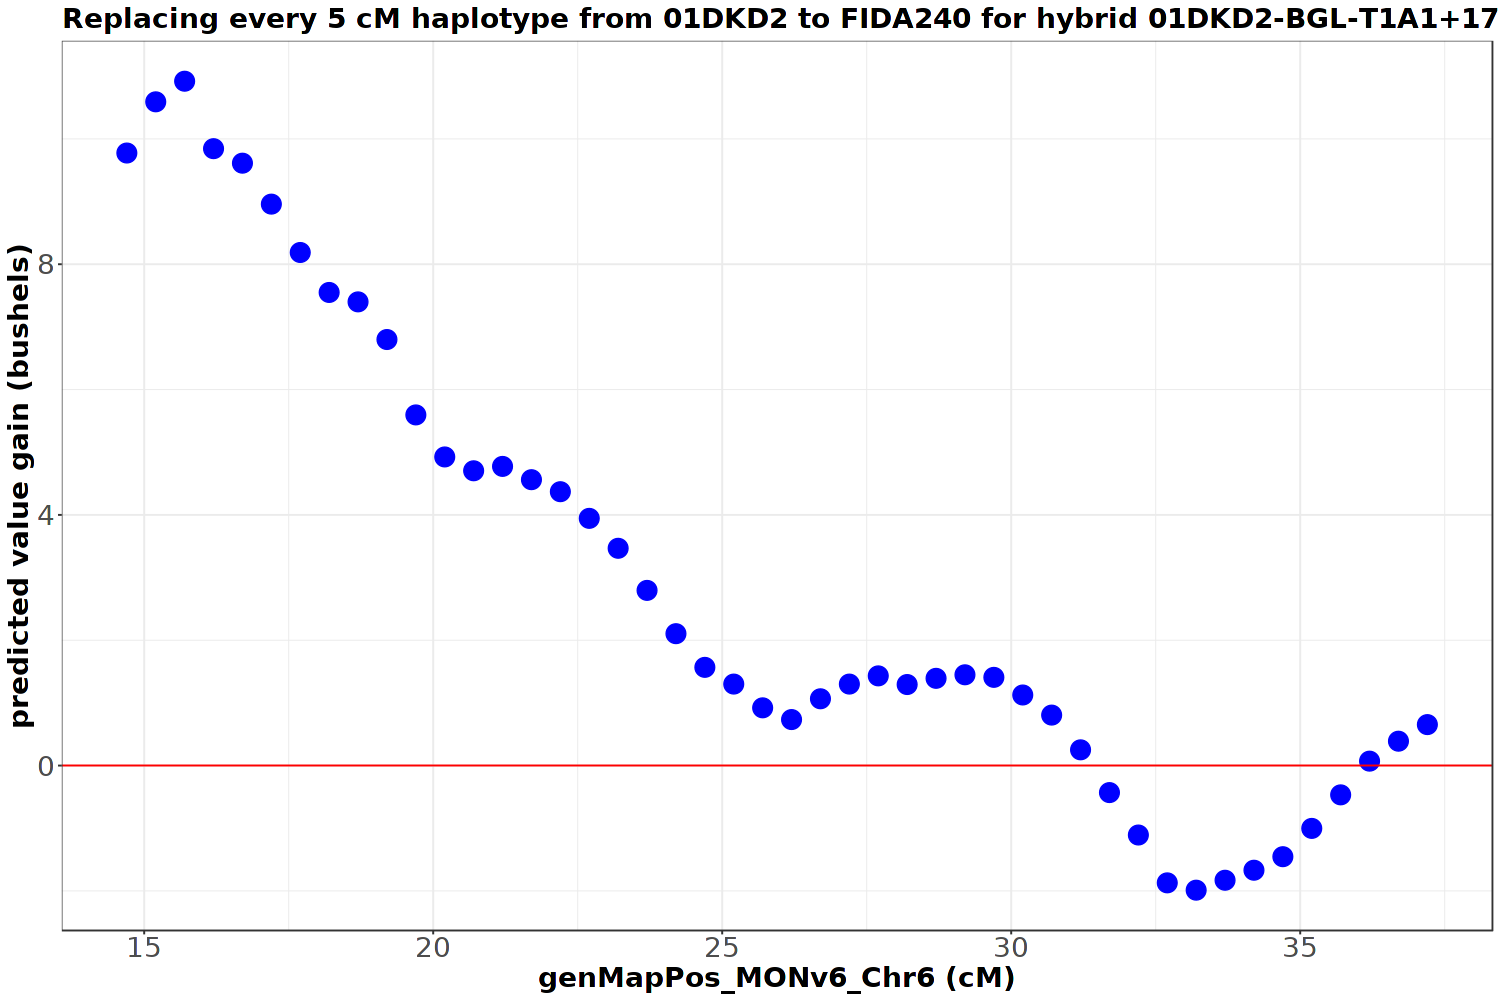

In [7]:
options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 100)
ggplot(mutPred,aes(genMapPos_MONv6 + 2.5,pred_value - baseValue)) + geom_point(col="blue",size=6) + theme_bw() + 
    geom_hline(yintercept = 0,col="red") + 
ggtitle("Replacing every 5 cM haplotype from 01DKD2 to FIDA240 for hybrid 01DKD2-BGL-T1A1+17IFI6") + 
xlab("genMapPos_MONv6_Chr6 (cM)") + ylab("predicted value gain (bushels)") + 
    theme(axis.text=element_text(size=20),plot.title = element_text(size = 20, face = "bold"),
        axis.title=element_text(size=20,face="bold"))

In [81]:
head(targetHap[1:5,1:10])

,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f,HB2__64DWA2_f
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,1,0,0,0,0
9965,0,0,0,0,0,1,0,0,0,0
9975,0,0,0,0,0,1,0,0,0,0
9985,0,0,0,0,0,1,0,0,0,0
9995,0,0,0,0,0,1,0,0,0,0


In [82]:
targetHap = targetHap[1,]

In [ ]:
# change the whole diff_chr6 from 01DKD2-BGL-T1A1 to FIDA240
targetHap[,31685:33206] = hapData[2,31685:33206]

In [ ]:
head(targetHap[,1:10])

In [ ]:
write.csv(targetHap,"/mnt/tmpData/01DKD2-BGL-T1A1_17IFI6_FIDA240Chr6.csv",row.names=F)

In [ ]:
colnames(targetHap)[32500]

## 17IFI6 to HINI403

In [39]:
hapData = read.csv("/mnt/tmpData/HINI403_17IFI6.csv")

In [ ]:
hapData[,1:10]

In [ ]:
row.names(hapData) = hapData[,1]
hapData = hapData[,-1]

In [ ]:
mmIndex = which(hapData[1,] != hapData[2,]) # mismatch haplotypes

In [ ]:
length(mmIndex)

In [ ]:
mmIndexName = colnames(hapData)[mmIndex]
mmBinIndex = as.numeric(sapply(mmIndexName,function(x){return(as.numeric(str_replace(unlist(strsplit(x,"__"))[1],"HB","")))}))

In [ ]:
head(mmBinIndex)

In [ ]:
head(mmIndexName)

In [ ]:
# only change chr2
indexRange = 2535:4342

In [ ]:
bins = 0
for(bin in unique(mmBinIndex)){
    if(bin %in% indexRange){
        tmp = targetHap[1,]
        index2 = which(mmBinIndex == bin)
        binNames = mmIndexName[index2]
        tmp[,binNames] = hapData["HINI403",binNames]

        targetHap = bind_rows(targetHap,tmp) 
        bins = c(bins,bin) 
    }
}
row.names(targetHap) = bins

In [ ]:
write.csv(targetHap,"/mnt/tmpData/mutatedHapToHINI403.csv")

In [ ]:
targetHap = read.csv("/mnt/tmpData/mutatedHapToHINI403.csv")

In [ ]:
head(bins)

In [43]:
mutPred = read.csv("/mnt/tmpData/pred_value_mutate_17IFI6_HINI403.csv")

In [44]:
head(mutPred)

,Unnamed..0,X0
,<int>,<dbl>
1,0,-30.31488
2,2535,-30.22140
3,2536,-30.25314
4,2537,-30.25163
5,2538,-30.22687
6,2539,-30.29281


In [45]:
colnames(mutPred) = c("binIndex","pred_value")
baseValue = mutPred$pred_value[1]
mutPred = mutPred[-1,]
mutPred$genMapChr_MONv6 = binMap[mutPred$binIndex,"genMapChr_MONv6"]
mutPred$genMapPos_MONv6 = binMap[mutPred$binIndex,"genMapPos_MONv6"]

In [46]:
head(mutPred)

,binIndex,pred_value,genMapChr_MONv6,genMapPos_MONv6
,<int>,<dbl>,<int>,<dbl>
2,2535,-30.22140,2,0.0
3,2536,-30.25314,2,0.1
4,2537,-30.25163,2,0.2
5,2538,-30.22687,2,0.3
6,2539,-30.29281,2,0.4
7,2540,-30.24127,2,0.5


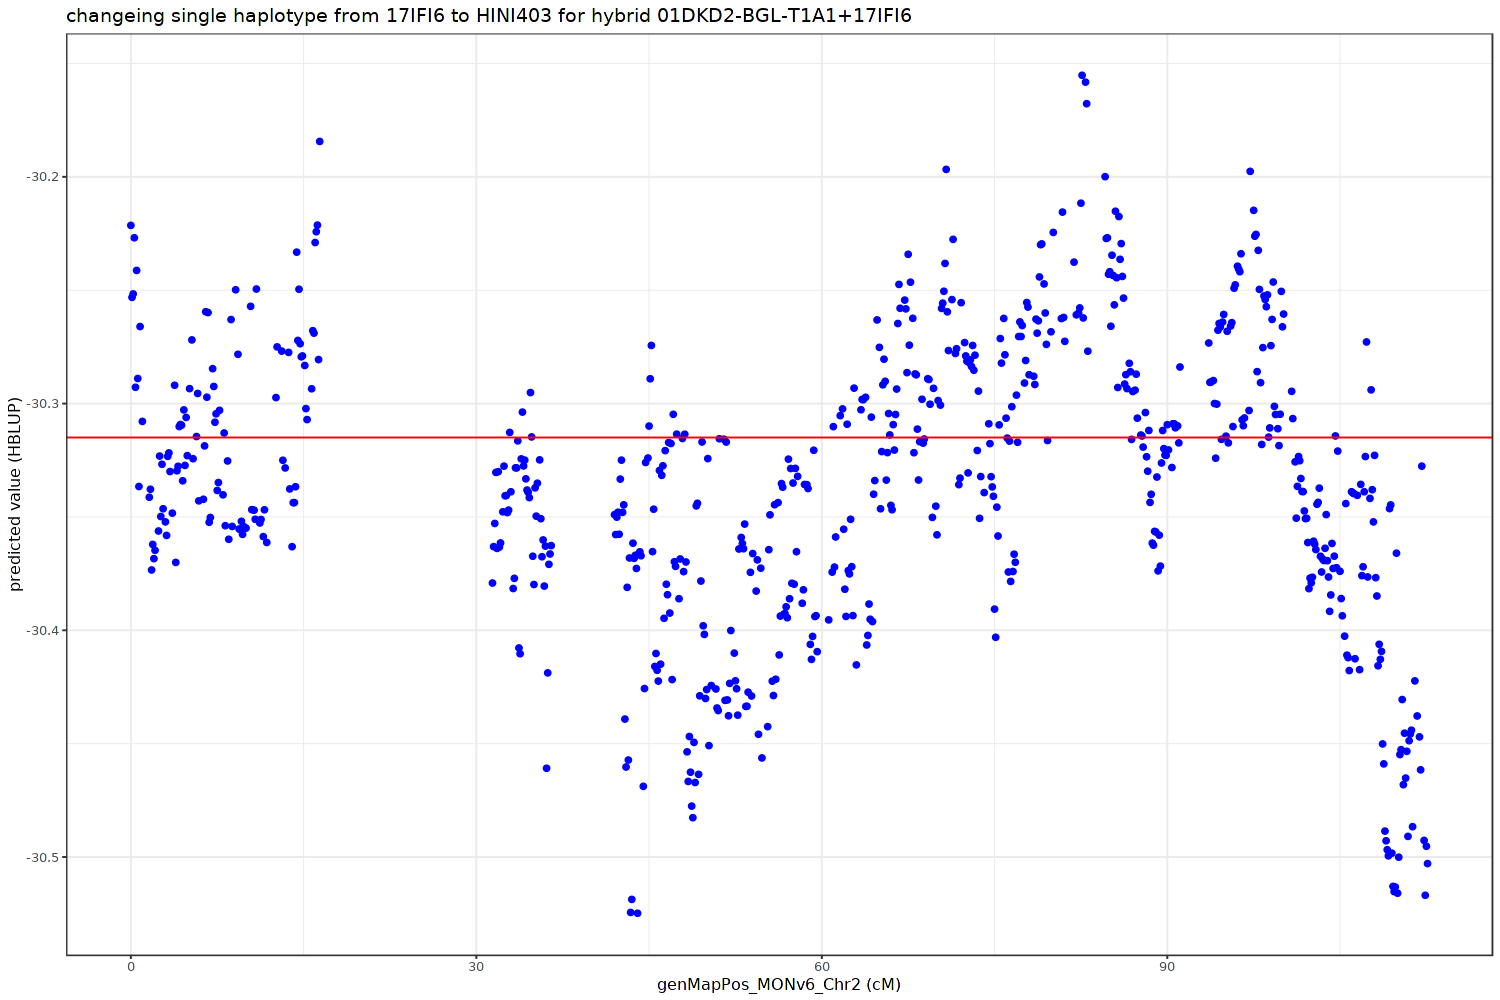

In [47]:
options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 100)
ggplot(mutPred,aes(genMapPos_MONv6,pred_value)) + geom_point(col="blue") + theme_bw() + 
    geom_hline(yintercept = baseValue,col="red") + 
ggtitle("changeing single haplotype from 17IFI6 to HINI403 for hybrid 01DKD2-BGL-T1A1+17IFI6") + 
xlab("genMapPos_MONv6_Chr2 (cM)") + ylab("predicted value (HBLUP)")

In [2]:
test = readRDS('/mnt/ML_HBLUP/NA_RM105_110_115/data/dummyMatrix_male.rds')

In [3]:
test[1:5,1:10]

,HB1__01HGI4,HB1__610,HB1__B14,HB1__LH287,HB1__M3AG-3,HB1__NA,HB1__OH43AE1,HB1__PH207,HB2__610,HB2__B14
LH287,0,0,0,2,0,0,0,0,0,0
83INI14,0,0,0,0,0,0,0,2,0,0
17IFI6,0,0,0,0,0,0,0,2,0,0
DILU757,0,0,0,0,0,0,0,2,0,0
GEJO564,2,0,0,0,0,0,0,0,0,0


In [4]:
test_hini = test[c("17IFI6","HINI403"),]

In [5]:
test_hini[,1:10]

,HB1__01HGI4,HB1__610,HB1__B14,HB1__LH287,HB1__M3AG-3,HB1__NA,HB1__OH43AE1,HB1__PH207,HB2__610,HB2__B14
17IFI6,0,0,0,0,0,0,0,2,0,0
HINI403,0,0,0,0,0,0,0,2,0,0


In [6]:
test_hini = t(test_hini)

In [7]:
test_hini[1:10,]

,17IFI6,HINI403
HB1__01HGI4,0,0
HB1__610,0,0
HB1__B14,0,0
HB1__LH287,0,0
HB1__M3AG-3,0,0
HB1__NA,0,0
HB1__OH43AE1,0,0
HB1__PH207,2,2
HB2__610,0,0
HB2__B14,0,0


In [8]:
write.csv(test_hini,"test_HINI403.csv")